# Emoji generator using GAN.
Addapted from Keras Minimal Viable GAN

In [1]:
import imageio
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm  # progress bars

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from keras import initializers

np.random.seed(10)
random_dim = 100


Using TensorFlow backend.


In [2]:
callback = [tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/keras-ckpt')]

In [3]:
# os.environ['TF_CONFIG'] = json.dumps({
#     'cluster': {
#         'worker': ["localhost:12345", "localhost:23456"]
#     },
#     'task': {'type': 'worker', 'index': 0}
# })


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#         print(e)

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [60]:
def discriminator_batch(generator, batch_size):
    x = 0
    fake_images, images = [], []
    while True:
        try:
            files = iter(os.listdir('people_emoji_final'))
            while x < batch_size:
                file = next(files)
                noise = np.random.normal(0, 1, size=[batch_size, random_dim])
                fake_image = generator.predict(noise)
                fake_image.resize((3888,))
                fake_images.append(fake_image)

                image = np.array(imageio.imread(os.path.join('people_emoji_final', file)))
                image = image / 255
                image.resize((3888,))
                images.append(image)
                x += 1
        except StopIteration:
            continue
        imgs = np.concatenate([images, fake_images])
        zeros = np.zeros(batch_size * 2)
        zeros[:batch_size] = 0.9
        yield imgs, zeros

def generator_batch(batch_size):
    x = 0
    images = []
    while True:
        try:
            files = iter(os.listdir('people_emoji_final'))
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            while x < batch_size:
                file = next(files)
                image = np.array(imageio.imread(os.path.join('people_emoji_final', file)))
                image = image / 255
                image.resize((3888,))
                images.append(image)
                x += 1
        except StopIteration:
            continue
        yield noise, np.array(images)

def gan_batch(batch_size):
    while True:
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])
        ones = np.ones(batch_size)
        yield noise, ones

def discriminator_pretrain_batch(batch_size):
    images = []
    x = 0
    while True:
        try:
            noise = np.random.normal(0, 1, size=[batch_size, 3888])
            files = iter(os.listdir('people_emoji_final'))
            while x < batch_size:
                file = next(files)
                image = np.array(imageio.imread(os.path.join('people_emoji_final', file)))
                image = image / 255
                image.resize((3888,))
                images.append(image)
                x += 1
        except StopIteration:
            continue
        y_dis = np.zeros(2 * batch_size)
        y_dis[:batch_size] = 0.9
        X = np.concatenate([images, noise])
        yield X, y_dis



In [27]:
def get_discriminator(optimizer):
# optimizer = Adam(lr=0.0002, beta_1=0.5)
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():

    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=3888,
                            kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim,
                        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(524))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1048))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(3888, activation='sigmoid'))
    generator.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan



In [28]:
 def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),
                           figsize=(15, 15)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 36, 36, 3)
 
    plt.figure(figsize=figsize)
    for i in range(10):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow((generated_images[i] * 255).astype(np.uint8), interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
#     if epoch == 25000:
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [73]:
def train(epochs=1, batch_size=32):
    # Get the training and testing data
    # Split the training data into batches of size 128
    batch_count = len(os.listdir('people_emoji_final')) // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    with tf.device('/gpu:0'):
        gen_batch = generator_batch(batch_size)
        g_batch = gan_batch(batch_size)
        generator = get_generator(adam)
    with tf.device('/gpu:1'):
        disp_batch = discriminator_pretrain_batch(batch_size)
        discriminator = get_discriminator(adam)
    with tf.device('/cpu:0'):
        dis_batch = discriminator_batch(generator, batch_size)
        gan = get_gan_network(discriminator, random_dim, generator, adam)


    # Pre-train generator and discriminator.
    for e in tqdm(range(1, 5000 + 1)):
        # Generator.
        generator.train_on_batch(*next(gen_batch))
#                                 epochs=epochs,
#                                 steps_per_epoch=batch_size,
#                                 use_multiprocessing=True,
#                                 workers=1,
#                                 verbose=2)

        # Discriminator.
        discriminator.trainable = True
        discriminator.train_on_batch(*next(disp_batch))
#                                     epochs=epochs,
#                                     steps_per_epoch=batch_size,
#                                     use_multiprocessing=True,
#                                     workers=1,
#                                     verbose=2)



    for e in tqdm(range(1, epochs + 1)):
        for _ in range(batch_count):
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(*next(dis_batch))
#                                         epochs=epochs,
#                                         steps_per_epoch=1,
#                                         use_multiprocessing=True,
#                                         workers=1,
#                                         verbose=2)

            # Train generator
            discriminator.trainable = False
            gan.train_on_batch(*next(g_batch))
#                               epochs=epochs,
#                               steps_per_epoch=1,
#                               use_multiprocessing=True,
#                               workers=1,
#                               verbose=2)

        if e % 5000 == 0:
            plot_generated_images(e, generator)
    return generator

In [74]:
epochs = 50

In [75]:
generator = train(epochs)

100%|██████████| 50/50 [02:17<00:00,  2.75s/it]


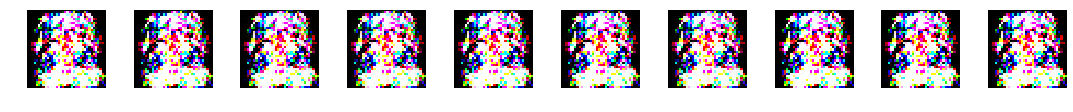

In [76]:
plot_generated_images(epochs, generator)

(-0.5, 35.5, 35.5, -0.5)

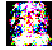

In [77]:
noise = np.random.normal(0, 1, size=[1, random_dim])
x = generator.predict(noise)
fig = plt.figure(dpi=15)
ax = fig.gca()
ax.imshow((x.reshape(36, 36, 3) * 255).astype(np.uint8), interpolation='nearest')
ax.axis('off')


In [67]:
from keras.models import load_model

In [ ]:
generator.save('people_generator_200k.h5')

In [ ]:
del generator

In [ ]:
generator = load_model('people_generator_200k.h5')

In [ ]:
noise = np.random.normal(0, 1, size=[1, random_dim])
x = generator.predict(noise)
fig = plt.figure(dpi=15)
ax = fig.gca()
ax.imshow((x.reshape(36, 36, 3) * 255).astype(np.uint8), interpolation='nearest')
ax.axis('off')
